In [2]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import json
import itertools

In [3]:
flex_dir = "dynamic/"
minimal_dir = "min/"
maximal_dir = "max/"

In [4]:
learning_steps = 1024000 * 2
n_steps_value = 2048 * 8
number_of_rollouts = learning_steps / n_steps_value

In [5]:
def string_to_list(string):
    string = string[1:-1]
    string = string.replace(" ", "")
    res = string.split(",")
    return [float(x) for x in res]    

def string_to_list_of_lists(string):
    res = []
    string = string[1:-1]
    string = string.replace(" ", "")
    outer_list = string.split("],")
    for inner_list in outer_list:
        tmp_str = inner_list+"]"
        res.append(tmp_str)
    res[-1] = res[-1][:-1]
    return [_list.strip("[]").split(",") for _list in res]

def combine_lists(attribute_list, folder_name):
    res = []
    for file in attribute_list:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list(data))
    return res

def combine_lists_distribution(list_of_text_files, folder_name):
    res = []
    for file in list_of_text_files:
        with open(folder_name+file, "r") as infile:
            data = infile.read()
            res.append(string_to_list_of_lists(data))
    return res

def mean_min_max(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in zip(*list_of_lists):
        _min.append(min(elements))
        _max.append(max(elements))
        _mean.append(sum(elements)/len(elements))
    return _mean, _min, _max  

def mean_min_max_distribution(list_of_lists):
    _mean = []
    _min = []
    _max = []
    for elements in itertools.zip_longest(*list_of_lists, fillvalue=0):
        float_elements = [float(x) for x in elements]
        _min.append(min(float_elements))
        _max.append(max(float_elements))
        _mean.append(sum(float_elements)/len(float_elements))
    return _mean, _min, _max

In [9]:
def plot_in_between(mean_min_max_list):
    _x = list(range(len(mean_min_max_list[0])))
    _y_mean = mean_min_max_list[0]
    _y_min = mean_min_max_list[1]
    _y_max = mean_min_max_list[2]
    plt.plot(_x, _y_mean)
    plt.fill_between(_x, _y_min, _y_max, alpha=0.3)
    plt.show()

def plot_by_metric(metric):
    metric_list_flex = [path for path in os.listdir(flex_dir) if metric in path]
    metric_list_min = [path for path in os.listdir(minimal_dir) if metric in path]
    metric_list_max = [path for path in os.listdir(maximal_dir) if metric in path]
    
    _y_flex_mean, _y_flex_min, _y_flex_max = mean_min_max(combine_lists(metric_list_flex, flex_dir))
    _y_min_mean, _y_min_min, _y_min_max = mean_min_max(combine_lists(metric_list_min, minimal_dir))
    _y_max_mean, _y_max_min, _y_max_max = mean_min_max(combine_lists(metric_list_max, maximal_dir))
    _x = list(range(len(_y_flex_mean)))
    
    plt.plot(_x, _y_flex_mean, color="blue")
    plt.plot(_x, _y_min_mean, color="green")
    plt.plot(_x, _y_max_mean, color="red")
    plt.grid()
    learning_step_ticks = [i*n_steps_value for i in _x]
    _x_ticks = np.arange(min(learning_step_ticks), max(learning_step_ticks)+1, n_steps_value)
    plt.xticks(_x[::15], _x_ticks[::15], rotation=45)
    
    plt.fill_between(_x, _y_flex_min, _y_flex_max, alpha=0.3, color="blue", label="dynamic")
    plt.fill_between(_x, _y_min_min, _y_min_max, alpha=0.3, color="green", label="min")
    plt.fill_between(_x, _y_max_min, _y_max_max, alpha=0.3, color="red", label="max")
    plt.legend(loc="best")
    plt.title(metric)
    plt.autoscale()
    plt.savefig(f"{metric}.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
    
def plot_trajectory(last_ten_trajectories):
    for run in last_ten_trajectories:
        _xs = []
        _ys = []
        for coordinate in run[:-1]:
            _xs.append(coordinate[0])
            _ys.append(coordinate[1]-95) # width / 2 - sprite / 2
        plt.plot(_xs, _ys)
    #plt.show()
    
    
def plot_distribution(last_ten_distributions):
    for run in last_ten_distributions:
        run = sum(run, [])
        _xs = list(range(len(run)))
        _ys = []
        
        for coordinate in run:
            _ys.append(coordinate)
        plt.plot(_xs, _ys, color='g')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.show()
    
    
def plot_complete_distribution(distribution):
    distri_list_flex = [path for path in os.listdir(flex_dir) if distribution in path]
    distri_list_min = [path for path in os.listdir(minimal_dir) if distribution in path]
    distri_list_max = [path for path in os.listdir(maximal_dir) if distribution in path]

    _flex_distris_outer = combine_lists_distribution(distri_list_flex, flex_dir)
    _flex_distri_combined = list(itertools.chain.from_iterable(_flex_distris_outer))

    _min_distris_outer = combine_lists_distribution(distri_list_min, minimal_dir)
    _min_distri_combined = list(itertools.chain.from_iterable(_min_distris_outer))

    _max_distris_outer = combine_lists_distribution(distri_list_max, maximal_dir)
    _max_distri_combined = list(itertools.chain.from_iterable(_max_distris_outer))

    combined_lists = _flex_distri_combined + _min_distri_combined + _max_distri_combined
    _y_combined_mean, _y_combined_min, _y_combined_max = mean_min_max_distribution(combined_lists)

    _x = list(range(len(_y_combined_mean)))

    plt.plot(_x, _y_combined_mean, color="blue")
    plt.fill_between(_x, _y_combined_min, _y_combined_max, alpha=0.3, color="blue", label="dynamic")
    plt.grid()
    plt.savefig(f"distribution_average.png", dpi=300, facecolor='white', edgecolor='none')
    plt.show()
    
def align_yaxis(ax1, ax2):
    y_lims = np.array([ax.get_ylim() for ax in [ax1, ax2]])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim1, new_lim2 = y_new_lims_normalized * y_mags
    ax1.set_ylim(new_lim1)
    ax2.set_ylim(new_lim2)
    
    
def combine_distri_trajectory(trajectory, distribution):

    t_xs = []
    t_ys = []
    for coordinate in trajectory[0][:-1]:
        #t_xs.append(coordinate[0])
        t_ys.append(coordinate[1])
    t_xs = [i for i in range(len(trajectory[0])-1)]
    
    fig, ax1 = plt.subplots()
    plt.grid()
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=80, color='brown', linestyle='dotted')
    plt.axhline(y=-80, color='brown', linestyle='dotted')
    
    color = 'tab:blue'
    ax1.set_xlabel('steps')
    ax1.set_ylabel('y_coords', color=color)
    ax1.plot(t_xs, t_ys)
    ax1.tick_params(axis='y', labelcolor=color)
    
    
    d_xs = [i for i in range(len(distribution[0]))]
    d_ys = []   
    for coordinate in distribution[0]:
        d_ys.append(coordinate)
    
    
    ax2 =ax1.twinx()
    
    color = 'tab:green'
    ax2.set_ylabel('wind', color=color)
    ax2.plot(d_xs, d_ys, color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)
    
    
    align_yaxis(ax1, ax2)
    fig.tight_layout()
    plt.savefig("distribution_trajectory_combination.png",facecolor='white', dpi=300, transparent=False)
    plt.show()
    
                 

In [10]:
plot_by_metric("commitment")
plot_by_metric("distance_traveled")
# plot_by_metric("number_of_actions") todo this metrics values are most likely wrong
plot_by_metric("rewards")
plot_by_metric("wins")
plot_by_metric("avg_steps_per_episode")
#plot_complete_distribution("complete_distribution")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dynamic/'

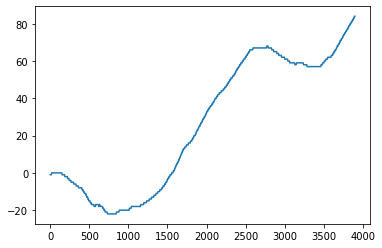

In [11]:
t="[[[5, 94], [10, 94], [15, 94], [20, 95], [25, 95], [30, 95], [35, 95], [40, 95], [45, 95], [50, 95], [55, 95], [60, 95], [65, 95], [70, 95], [75, 95], [80, 95], [85, 95], [90, 95], [95, 95], [100, 95], [105, 95], [110, 95], [115, 95], [120, 95], [125, 95], [130, 95], [135, 95], [140, 95], [145, 95], [150, 95], [155, 94], [160, 94], [165, 94], [170, 94], [175, 94], [180, 94], [185, 94], [190, 93], [195, 93], [200, 93], [205, 93], [210, 93], [215, 93], [220, 93], [225, 92], [230, 92], [235, 92], [240, 92], [245, 91], [250, 91], [255, 91], [260, 91], [265, 91], [270, 90], [275, 90], [280, 90], [285, 90], [290, 90], [295, 90], [300, 90], [305, 89], [310, 89], [315, 89], [320, 89], [325, 89], [330, 89], [335, 88], [340, 88], [345, 88], [350, 88], [355, 88], [360, 88], [365, 87], [370, 87], [375, 87], [380, 87], [385, 87], [390, 87], [395, 87], [400, 87], [405, 87], [410, 86], [415, 86], [420, 86], [425, 85], [430, 85], [435, 85], [440, 84], [445, 84], [450, 84], [455, 84], [460, 83], [465, 83], [470, 82], [475, 82], [480, 82], [485, 81], [490, 81], [495, 80], [500, 80], [505, 80], [510, 80], [515, 79], [520, 79], [525, 79], [530, 78], [535, 78], [540, 78], [545, 78], [550, 78], [555, 78], [560, 78], [565, 77], [570, 77], [575, 77], [580, 77], [585, 78], [590, 78], [595, 78], [600, 78], [605, 78], [610, 78], [615, 78], [620, 78], [625, 77], [630, 78], [635, 78], [640, 77], [645, 77], [650, 77], [655, 77], [660, 77], [665, 77], [670, 77], [675, 76], [680, 76], [685, 76], [690, 75], [695, 75], [700, 75], [705, 74], [710, 74], [715, 74], [720, 74], [725, 74], [730, 74], [735, 73], [740, 73], [745, 73], [750, 73], [755, 73], [760, 73], [765, 73], [770, 73], [775, 73], [780, 73], [785, 73], [790, 73], [795, 73], [800, 73], [805, 73], [810, 73], [815, 73], [820, 73], [825, 73], [830, 73], [835, 73], [840, 73], [845, 73], [850, 74], [855, 74], [860, 74], [865, 74], [870, 74], [875, 74], [880, 74], [885, 75], [890, 75], [895, 75], [900, 75], [905, 75], [910, 75], [915, 75], [920, 75], [925, 75], [930, 75], [935, 75], [940, 75], [945, 75], [950, 75], [955, 75], [960, 75], [965, 75], [970, 75], [975, 75], [980, 75], [985, 75], [990, 75], [995, 75], [1000, 75], [1005, 75], [1010, 75], [1015, 76], [1020, 76], [1025, 76], [1030, 76], [1035, 76], [1040, 77], [1045, 77], [1050, 77], [1055, 77], [1060, 77], [1065, 77], [1070, 77], [1075, 77], [1080, 77], [1085, 77], [1090, 77], [1095, 77], [1100, 77], [1105, 77], [1110, 77], [1115, 77], [1120, 77], [1125, 77], [1130, 77], [1135, 77], [1140, 77], [1145, 77], [1150, 77], [1155, 77], [1160, 78], [1165, 78], [1170, 78], [1175, 78], [1180, 78], [1185, 78], [1190, 78], [1195, 78], [1200, 79], [1205, 79], [1210, 79], [1215, 79], [1220, 79], [1225, 79], [1230, 79], [1235, 80], [1240, 80], [1245, 80], [1250, 80], [1255, 80], [1260, 80], [1265, 80], [1270, 81], [1275, 81], [1280, 81], [1285, 81], [1290, 81], [1295, 81], [1300, 82], [1305, 82], [1310, 82], [1315, 82], [1320, 82], [1325, 82], [1330, 83], [1335, 83], [1340, 83], [1345, 83], [1350, 83], [1355, 84], [1360, 84], [1365, 84], [1370, 84], [1375, 84], [1380, 85], [1385, 85], [1390, 85], [1395, 85], [1400, 85], [1405, 86], [1410, 86], [1415, 86], [1420, 86], [1425, 86], [1430, 87], [1435, 87], [1440, 87], [1445, 88], [1450, 88], [1455, 88], [1460, 88], [1465, 89], [1470, 89], [1475, 89], [1480, 90], [1485, 90], [1490, 90], [1495, 91], [1500, 91], [1505, 92], [1510, 92], [1515, 92], [1520, 93], [1525, 93], [1530, 93], [1535, 94], [1540, 94], [1545, 94], [1550, 94], [1555, 95], [1560, 95], [1565, 95], [1570, 95], [1575, 96], [1580, 96], [1585, 96], [1590, 97], [1595, 97], [1600, 98], [1605, 98], [1610, 99], [1615, 99], [1620, 100], [1625, 100], [1630, 100], [1635, 101], [1640, 101], [1645, 102], [1650, 102], [1655, 103], [1660, 103], [1665, 104], [1670, 104], [1675, 105], [1680, 105], [1685, 106], [1690, 106], [1695, 107], [1700, 107], [1705, 108], [1710, 108], [1715, 108], [1720, 108], [1725, 109], [1730, 109], [1735, 109], [1740, 109], [1745, 110], [1750, 110], [1755, 110], [1760, 110], [1765, 110], [1770, 111], [1775, 111], [1780, 111], [1785, 111], [1790, 111], [1795, 112], [1800, 112], [1805, 112], [1810, 112], [1815, 113], [1820, 113], [1825, 113], [1830, 114], [1835, 114], [1840, 115], [1845, 115], [1850, 115], [1855, 115], [1860, 116], [1865, 116], [1870, 117], [1875, 117], [1880, 118], [1885, 118], [1890, 118], [1895, 119], [1900, 119], [1905, 120], [1910, 120], [1915, 120], [1920, 121], [1925, 121], [1930, 122], [1935, 122], [1940, 122], [1945, 123], [1950, 123], [1955, 124], [1960, 124], [1965, 124], [1970, 125], [1975, 125], [1980, 125], [1985, 126], [1990, 126], [1995, 127], [2000, 127], [2005, 128], [2010, 128], [2015, 128], [2020, 129], [2025, 129], [2030, 129], [2035, 130], [2040, 130], [2045, 130], [2050, 131], [2055, 131], [2060, 131], [2065, 131], [2070, 132], [2075, 132], [2080, 132], [2085, 133], [2090, 133], [2095, 133], [2100, 134], [2105, 134], [2110, 135], [2115, 135], [2120, 135], [2125, 135], [2130, 136], [2135, 136], [2140, 136], [2145, 137], [2150, 137], [2155, 137], [2160, 137], [2165, 138], [2170, 138], [2175, 138], [2180, 138], [2185, 138], [2190, 139], [2195, 139], [2200, 139], [2205, 139], [2210, 139], [2215, 140], [2220, 140], [2225, 140], [2230, 140], [2235, 141], [2240, 141], [2245, 141], [2250, 141], [2255, 142], [2260, 142], [2265, 142], [2270, 143], [2275, 143], [2280, 143], [2285, 144], [2290, 144], [2295, 144], [2300, 145], [2305, 145], [2310, 145], [2315, 146], [2320, 146], [2325, 146], [2330, 146], [2335, 147], [2340, 147], [2345, 147], [2350, 147], [2355, 148], [2360, 148], [2365, 148], [2370, 149], [2375, 149], [2380, 150], [2385, 150], [2390, 150], [2395, 151], [2400, 151], [2405, 151], [2410, 152], [2415, 152], [2420, 152], [2425, 153], [2430, 153], [2435, 153], [2440, 154], [2445, 154], [2450, 154], [2455, 154], [2460, 155], [2465, 155], [2470, 155], [2475, 156], [2480, 156], [2485, 156], [2490, 156], [2495, 157], [2500, 157], [2505, 157], [2510, 158], [2515, 158], [2520, 158], [2525, 159], [2530, 159], [2535, 159], [2540, 160], [2545, 160], [2550, 160], [2555, 161], [2560, 161], [2565, 161], [2570, 161], [2575, 161], [2580, 161], [2585, 161], [2590, 161], [2595, 162], [2600, 162], [2605, 162], [2610, 162], [2615, 162], [2620, 162], [2625, 162], [2630, 162], [2635, 162], [2640, 162], [2645, 162], [2650, 162], [2655, 162], [2660, 162], [2665, 162], [2670, 162], [2675, 162], [2680, 162], [2685, 162], [2690, 162], [2695, 162], [2700, 162], [2705, 162], [2710, 162], [2715, 162], [2720, 162], [2725, 162], [2730, 162], [2735, 162], [2740, 162], [2745, 162], [2750, 162], [2755, 162], [2760, 162], [2765, 162], [2770, 163], [2775, 163], [2780, 163], [2785, 163], [2790, 162], [2795, 162], [2800, 162], [2805, 162], [2810, 162], [2815, 162], [2820, 162], [2825, 162], [2830, 162], [2835, 161], [2840, 161], [2845, 161], [2850, 161], [2855, 161], [2860, 160], [2865, 160], [2870, 160], [2875, 160], [2880, 160], [2885, 160], [2890, 160], [2895, 160], [2900, 159], [2905, 159], [2910, 159], [2915, 159], [2920, 159], [2925, 158], [2930, 158], [2935, 158], [2940, 158], [2945, 158], [2950, 158], [2955, 158], [2960, 157], [2965, 157], [2970, 157], [2975, 157], [2980, 157], [2985, 157], [2990, 157], [2995, 157], [3000, 156], [3005, 156], [3010, 156], [3015, 156], [3020, 156], [3025, 156], [3030, 156], [3035, 156], [3040, 155], [3045, 155], [3050, 155], [3055, 155], [3060, 155], [3065, 154], [3070, 154], [3075, 154], [3080, 154], [3085, 154], [3090, 154], [3095, 154], [3100, 154], [3105, 154], [3110, 154], [3115, 154], [3120, 154], [3125, 154], [3130, 153], [3135, 153], [3140, 153], [3145, 153], [3150, 154], [3155, 154], [3160, 154], [3165, 154], [3170, 154], [3175, 154], [3180, 154], [3185, 154], [3190, 154], [3195, 154], [3200, 154], [3205, 154], [3210, 154], [3215, 154], [3220, 154], [3225, 154], [3230, 154], [3235, 154], [3240, 153], [3245, 153], [3250, 153], [3255, 153], [3260, 153], [3265, 153], [3270, 153], [3275, 153], [3280, 153], [3285, 152], [3290, 152], [3295, 152], [3300, 152], [3305, 152], [3310, 152], [3315, 152], [3320, 152], [3325, 152], [3330, 152], [3335, 152], [3340, 152], [3345, 152], [3350, 152], [3355, 152], [3360, 152], [3365, 152], [3370, 152], [3375, 152], [3380, 152], [3385, 152], [3390, 152], [3395, 152], [3400, 152], [3405, 152], [3410, 152], [3415, 152], [3420, 152], [3425, 152], [3430, 152], [3435, 152], [3440, 152], [3445, 152], [3450, 152], [3455, 152], [3460, 152], [3465, 153], [3470, 153], [3475, 153], [3480, 153], [3485, 154], [3490, 154], [3495, 154], [3500, 154], [3505, 155], [3510, 155], [3515, 155], [3520, 155], [3525, 156], [3530, 156], [3535, 156], [3540, 156], [3545, 156], [3550, 157], [3555, 157], [3560, 157], [3565, 157], [3570, 157], [3575, 157], [3580, 157], [3585, 157], [3590, 157], [3595, 158], [3600, 158], [3605, 158], [3610, 158], [3615, 159], [3620, 159], [3625, 159], [3630, 160], [3635, 160], [3640, 160], [3645, 161], [3650, 161], [3655, 161], [3660, 162], [3665, 162], [3670, 163], [3675, 163], [3680, 163], [3685, 164], [3690, 164], [3695, 164], [3700, 165], [3705, 165], [3710, 166], [3715, 166], [3720, 166], [3725, 167], [3730, 167], [3735, 167], [3740, 168], [3745, 168], [3750, 169], [3755, 169], [3760, 169], [3765, 170], [3770, 170], [3775, 170], [3780, 171], [3785, 171], [3790, 171], [3795, 172], [3800, 172], [3805, 172], [3810, 173], [3815, 173], [3820, 174], [3825, 174], [3830, 174], [3835, 175], [3840, 175], [3845, 175], [3850, 176], [3855, 176], [3860, 176], [3865, 177], [3870, 177], [3875, 177], [3880, 178], [3885, 178], [3890, 179], [3895, 179], [0, 95]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]]]"
plot_trajectory(json.loads(t))

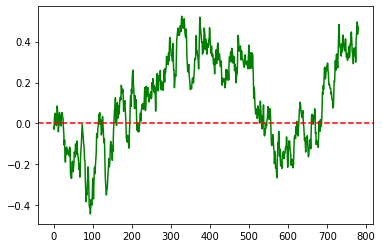

In [12]:
d="[[[-0.01882549636410929], [-0.028504787210063946], [0.030144437314632462], [0.03841375066241195], [0.04996678611994687], [0.03584831344550385], [-0.007090599947944025], [-0.01072423791806276], [0.021917336964286063], [0.08533501957384562], [0.06180850202631444], [0.03026399336362346], [-0.041276857664770045], [-0.014808841458091058], [-0.006562283807942994], [0.05225062725702015], [0.030877692787949135], [0.017425861482021958], [0.03665787777383958], [-0.012261904509456613], [0.033477741019084725], [0.0529479546694287], [0.049150949526000284], [0.030178806880257394], [0.024246988374365917], [-0.02420658371201096], [-0.05153279156576342], [-0.10685507749613324], [-0.08047229340700505], [-0.16580419190124607], [-0.18884997378378207], [-0.14937887166959085], [-0.1355029203437748], [-0.1155282329903382], [-0.15103900454886185], [-0.12324073660022337], [-0.12869864938694808], [-0.13736378564199803], [-0.14438125654781647], [-0.1457275449904416], [-0.1585777623499025], [-0.1156171649881329], [-0.1342585623131229], [-0.2464588576867543], [-0.2595691463226575], [-0.26759121293998894], [-0.2684897411916816], [-0.19770926264205585], [-0.18447708467705848], [-0.20834864329496797], [-0.23596268824422906], [-0.21150687017609882], [-0.18932941172036544], [-0.13991122098667208], [-0.16491325405087762], [-0.14810216628896544], [-0.09993656322116398], [-0.12229058793293747], [-0.15121463047553507], [-0.12200633805127367], [-0.0856694765156139], [-0.14359232189810997], [-0.15773971129894518], [-0.16682221456512109], [-0.1962844497811347], [-0.22568819644323176], [-0.19640644155295334], [-0.2624129610914233], [-0.21842451733686918], [-0.15505936462050096], [-0.12797110339699813], [-0.09347599697150369], [-0.047631228393072614], [-0.004453582636590528], [-0.030933581326065752], [-0.06390256453986874], [-0.08697192030706209], [-0.10387815637104428], [-0.11859125859355517], [-0.1772186053377282], [-0.1804318703507274], [-0.2732948071050555], [-0.3362143332273524], [-0.3826154399599856], [-0.3343523683545925], [-0.3501847363551397], [-0.31319916711502666], [-0.26704560767189395], [-0.21220008574348925], [-0.24731754817513657], [-0.33401873939679316], [-0.40011680343065353], [-0.4108971799620715], [-0.41423742049700174], [-0.44204954897589793], [-0.410832111724339], [-0.3715009001985751], [-0.3989979993011471], [-0.39857580563250644], [-0.3417141064600376], [-0.26768593889233205], [-0.30110137827078187], [-0.36892964147412266], [-0.2942524490740951], [-0.21966701870752017], [-0.21300395412920534], [-0.24528379697667474], [-0.19887934229100573], [-0.17441404021538784], [-0.13984204474523235], [-0.05028354456845732], [-0.05332902449967222], [-0.06981023553591309], [-0.02390753914146785], [-0.017607887376908892], [0.013715788112372292], [0.045814936194654377], [0.03320731050566782], [0.0519855519757028], [-0.004602744553683397], [0.019252888051594485], [0.011320914837012185], [-0.056400001699016516], [-0.04452491912551068], [-0.020249191622737937], [0.03380906336606561], [0.0034941425927349154], [-0.041301152584347224], [-0.07448103209311996], [-0.09402660009573703], [-0.07616682360486336], [-0.17641262884549203], [-0.255955865158025], [-0.29549106253311047], [-0.3299412153954503], [-0.3497089988666118], [-0.32414447089943293], [-0.31626841176705384], [-0.2889319608078994], [-0.24799132075295158], [-0.22251443919016306], [-0.17236636248207815], [-0.2126284015207882], [-0.20906674809002448], [-0.17339819267751147], [-0.11727137022029649], [-0.08772225573730005], [-0.1107177903069927], [-0.13827246059298862], [-0.10592093507096687], [-0.18021358222482003], [-0.12336780202506525], [-0.1348399293318913], [-0.043327513605367116], [-0.0033309236794510713], [0.031537534840688906], [0.0714438322966374], [0.05989139444232013], [0.12529943721961895], [0.004547330895472768], [0.017352251497012], [-0.010149368796082053], [0.08673304750754794], [0.1017689395393786], [0.024278547206975115], [0.07419026859322891], [0.08646683863913113], [0.04525687463832443], [0.06486823164817829], [0.10583194216671235], [0.12567510736327084], [0.12757808051619712], [0.11479245956246335], [0.18642159751382936], [0.17623853766037423], [0.14985378820690748], [0.1493804399089793], [0.1674222686260963], [0.1291107306521693], [0.059658656201015306], [0.07028489456372342], [0.09448554080759979], [0.11136203241562137], [0.07748097847757324], [0.04316593955889418], [0.005524484494545276], [-0.07184001417240644], [-0.06623880321171827], [-0.09077617802172402], [-0.05776638363542145], [-0.06600202652518602], [-0.08075215321568195], [-0.11271819517251425], [-0.12108077290778042], [-0.03183579668304366], [0.0014093980493432648], [0.09493903072486638], [0.13624417478300432], [0.08254263115520005], [0.16629966161971016], [0.14585097403192704], [0.21566737205535152], [0.2453049122343052], [0.26065662175514903], [0.19669865758029978], [0.16986929357033978], [0.1233447354747369], [0.0732759661413723], [0.13619310983138255], [0.08927821102399733], [0.0761312043385742], [0.11602428735316442], [0.03222921814022306], [-0.028500378366848315], [-0.03438234316987579], [0.0011175226915365322], [-0.040815019862503694], [-0.015819260036278492], [-0.04032031663472904], [-0.01550386713131658], [-0.008162031306208153], [0.026331816613285597], [0.05041227288189305], [0.011558688460082456], [0.058755673241933405], [0.07200835019918753], [0.0904382190787089], [0.09416108731024185], [0.07249384262776741], [0.0963215896345472], [0.06872589482986584], [0.08492871679248938], [0.11909088092520467], [0.17548978568832638], [0.14714316360300303], [0.06284025972226946], [0.09471264350016632], [0.18191695857929457], [0.13158965400188843], [0.15805675270570566], [0.1652723597170266], [0.1760517261922975], [0.14714008291926386], [0.11262613512190942], [0.10435535775342068], [0.11902525896322688], [0.14031359893017875], [0.1254239165556927], [0.15437042945500482], [0.12164896023523723], [0.12166840861692982], [0.12932708310037308], [0.2001091624645624], [0.17201359248454626], [0.2191432074744364], [0.18662745572270228], [0.15866828930102883], [0.18575025806513468], [0.14992405180008728], [0.1750780496024537], [0.1421989802691492], [0.06014077297143494], [0.14430526915171582], [0.1926594686135889], [0.22066230301020912], [0.2444164067007785], [0.18731405386719183], [0.15952799936023465], [0.16290228067712004], [0.21253389046132545], [0.23603676404678445], [0.21102146744087616], [0.236451927666964], [0.25882324839077825], [0.16480757004789606], [0.20647355335291276], [0.17260541363445014], [0.18810287529801809], [0.19895045915246015], [0.16171868268691653], [0.1624813247358654], [0.20958125229257643], [0.21304591897005629], [0.26230119399463997], [0.20201021361448826], [0.26748643383687415], [0.2463458447259586], [0.2605400105028691], [0.27614657275463916], [0.32818788204442567], [0.29720501064678484], [0.304372122940924], [0.3066543644512588], [0.2870305600881594], [0.3453406581116994], [0.3042842474005226], [0.36729045085805934], [0.42065297388814865], [0.4050533909799139], [0.37254738359890766], [0.3605940175447166], [0.33043880217216537], [0.3321367025078595], [0.33684006051444737], [0.30447248414525246], [0.3914232362015285], [0.3340628292778468], [0.26009061320168714], [0.2604480433761234], [0.1743291158583879], [0.20014524718478627], [0.2399327086546711], [0.23237796155906723], [0.23096180707772007], [0.3236321568185157], [0.410273699660054], [0.42963341962502094], [0.44851119218023006], [0.46594635098204995], [0.43061701164662936], [0.4311341811509313], [0.4410470594695999], [0.431927738517251], [0.46033368867053726], [0.477089476857082], [0.4706853682205887], [0.4484275798884765], [0.5122871807147011], [0.5237501531579879], [0.4686160245811014], [0.5043675208000821], [0.4890852409615281], [0.4642455447926861], [0.4919521942765317], [0.5115842309424804], [0.48235551251194847], [0.4406406127682719], [0.427761428842197], [0.41912729060258913], [0.4612033151309906], [0.42448895437400846], [0.3310937087358213], [0.28966221536888637], [0.2539010845021048], [0.25196292123823844], [0.2808043306738662], [0.2884189546392195], [0.22998697171881222], [0.21327294098171662], [0.1875378401025274], [0.16533225812344368], [0.1806432013958894], [0.17880369334962176], [0.16974179922249547], [0.19303939837127795], [0.21980024905720838], [0.2228475229111678], [0.20727027071989082], [0.197946904772826], [0.2334775803577885], [0.2586079245532568], [0.31653295294873457], [0.3125182030120956], [0.3129635802402503], [0.37836019650215424], [0.4298883231959901], [0.34357633302183105], [0.354067678582779], [0.3342939719923041], [0.32503022747010973], [0.30326553332963446], [0.26640632978104545], [0.33099160911923814], [0.4218742995135262], [0.518823028133484], [0.48694018419956], [0.465585888539756], [0.44914396409094226], [0.4206786898626296], [0.39582677962700336], [0.3997253603735423], [0.33874330716892254], [0.35256941765154204], [0.34986514191328133], [0.3746556656651566], [0.46637639362574507], [0.4565745657311265], [0.435274936837266], [0.36122821310367925], [0.4124716721005067], [0.3961348701337563], [0.3738197644019305], [0.3383459526767166], [0.36073796022419197], [0.39088007684260373], [0.37831100958476016], [0.3721036705899135], [0.4104991196515424], [0.41268203130586545], [0.46727363337775324], [0.44155034839412866], [0.382926396588023], [0.37866131152226196], [0.3418279517249055], [0.37731896996636016], [0.33919667623099214], [0.32690548337963443], [0.3380282446685324], [0.321583857467856], [0.2894818296955305], [0.2886244690812852], [0.2907322699014633], [0.24230125883642067], [0.3177925803524731], [0.28855573852674427], [0.33471723389404373], [0.3606325394489267], [0.29216372563236526], [0.31601003223543844], [0.3706347653367657], [0.3931978606395685], [0.3855693269565026], [0.31031835908461847], [0.31691362238289555], [0.34118163196802076], [0.3294676126475122], [0.2844433016020255], [0.2774345273598337], [0.28401801912902047], [0.30553580730132224], [0.22638086578682987], [0.18666269965700533], [0.22105943287674076], [0.21877186362724774], [0.21173649789210133], [0.2032110462227506], [0.21917586787642945], [0.2112961445628223], [0.17408847758405696], [0.18803757002084323], [0.19072014331295806], [0.26268085245475914], [0.24410597231197032], [0.26360666668953786], [0.2252662780263621], [0.2118167956558248], [0.251812554123842], [0.2519619986983565], [0.2122018571777119], [0.29906319851726626], [0.32580457892452264], [0.30299908527553854], [0.3215521329893959], [0.3512892263884113], [0.3001313941001369], [0.32593377008384056], [0.3672264194114698], [0.34837687039210813], [0.33677723234445334], [0.2950480454138986], [0.30945281807296654], [0.3276382476200327], [0.3115154583303685], [0.2579944922904277], [0.29048547531679664], [0.26379333417496553], [0.2367980131073463], [0.19895558476571604], [0.2288847048201364], [0.27299821958789], [0.2427214147237265], [0.3522233014766452], [0.43009805005070806], [0.41680986733510217], [0.3753758768450463], [0.35607395436688655], [0.3521603734898233], [0.36656442183147514], [0.3784087863302557], [0.3533082052460345], [0.30993280025336245], [0.3545113817518964], [0.3223281622648908], [0.3171046110972815], [0.31380350992525435], [0.3044638526235923], [0.2919509086767192], [0.27811664876953424], [0.27435965182221256], [0.2855441677204365], [0.33528654179948164], [0.2926962731541768], [0.29829905860185385], [0.30432387141186446], [0.28831104709692995], [0.30362544842569045], [0.2785599597550155], [0.2667142953809226], [0.3126298190384579], [0.35155070423419776], [0.38269688199237045], [0.29604122812971645], [0.26686007882402274], [0.27757553953420233], [0.3069354782393814], [0.34562763045497136], [0.33087049657427653], [0.3452968845513985], [0.2696779928321027], [0.3373233372103749], [0.2794317735886343], [0.23373579977894374], [0.1218042577107813], [0.177544649753194], [0.16078166888813905], [0.09832189714346982], [0.0735570410415645], [0.04560418815909331], [0.0713347317191338], [0.04827323034322613], [0.06816975661282264], [0.02438604887995787], [0.04030096343001441], [0.08581729901330716], [0.050363685054533716], [0.06765606526400067], [0.03577823155457547], [0.002047018818759447], [0.05570831274779642], [0.1087877895289946], [0.07853986328535378], [0.029265308657978925], [-0.0009610640881339283], [-0.026615927233088275], [0.036209273236419745], [0.03141683683504504], [0.011768762967224362], [0.09044240675572407], [-0.016563826256283026], [-0.0605383346996319], [-0.06010845851141184], [-0.054389504354657635], [-0.02314563266707108], [-0.024138594354270907], [0.0008179255509551467], [-0.01090568805882055], [0.019208137655467247], [0.021175841069831388], [0.060171529195568924], [0.08281329136410161], [0.043489154837110085], [0.06513634991198931], [0.019862960231289438], [0.07303137907431265], [0.06153175982163345], [0.03738602210556341], [-0.021997951963361226], [-0.08866909004623989], [-0.10826136308172249], [-0.09611162964639061], [-0.10158913369784682], [-0.054556701600699704], [-0.08002140174623143], [-0.11493373294346196], [-0.13013377525016834], [-0.19643936603627704], [-0.16013506019252205], [-0.13862139318941483], [-0.21876813255894922], [-0.2133466018920831], [-0.2190573620619915], [-0.2655955220849172], [-0.20295096156142556], [-0.1304925454616968], [-0.09375504156883037], [-0.10412750208808758], [-0.03895595265603169], [-0.08886137581349737], [-0.15812368698945894], [-0.1243452379990419], [-0.1766869797519241], [-0.20798313535384189], [-0.18031096634682636], [-0.1915004234128762], [-0.22006556634352803], [-0.15869666593972542], [-0.14739446837209771], [-0.14617608192157264], [-0.136706610944755], [-0.17256863384614732], [-0.14884342679422527], [-0.15020837964227607], [-0.14560637164081963], [-0.12210966899543671], [-0.11588599366602054], [-0.11962701918154255], [-0.06578675960367347], [-0.09675869037883464], [-0.15956278778151584], [-0.21410586734227008], [-0.16423184722862336], [-0.12159120707012372], [-0.08506002554100855], [-0.09136337873043254], [-0.08715871928372056], [-0.1271518315026935], [-0.1378499111784437], [-0.15649356238006168], [-0.20508692098136572], [-0.1755676195209425], [-0.1756231269824402], [-0.17991933231223298], [-0.21153323951649533], [-0.21661936190506753], [-0.19538064192394455], [-0.12050220380752527], [-0.0672504163793432], [-0.06129395619688199], [-0.058678419218473235], [-0.07409182215022837], [-0.016878674683474454], [-0.04944930423661997], [0.010183535521222697], [-0.05403823603640709], [-0.0327788721628573], [-0.061499189302269275], [-0.04830427089909546], [-0.012341042917645595], [0.03377874152242496], [0.0678108950385615], [0.07691819818901369], [0.1038971872928604], [0.09035688873888378], [0.05936257997544746], [0.04835734932949154], [0.02930924450551546], [0.03966808641854627], [0.053375284215825256], [0.062579129676225], [-0.007087018474409235], [-0.008465413740185328], [-0.046862118368151365], [-0.0830667433557301], [-0.06820300627549881], [-0.09652974559086855], [-0.13988882490903218], [-0.0895466854043692], [-0.09914477396266151], [-0.09542678369984252], [-0.0601084753753711], [-0.08103805216733588], [-0.13147758681624866], [-0.1625267230939059], [-0.15499206693941273], [-0.11750786743365249], [-0.11303293929158587], [-0.08648181687914017], [-0.07830278817794462], [-0.1239854182799737], [-0.037436661011435654], [0.0335837664293841], [0.0450106226035201], [0.007930157453347096], [0.004852607683925762], [-0.0037191035881094636], [0.00891134743486053], [0.03878546846677313], [0.023279891728810488], [0.071618230318704], [0.05582323046741741], [-0.04875401037882358], [-0.04341975998751079], [-0.10353034847615197], [-0.08338928002477297], [-0.09158047235698537], [-0.10045205883571322], [-0.09503774544836416], [-0.1171940788411503], [-0.06738565049937148], [0.009256750157984939], [-0.030148077640939373], [0.010365964952574885], [-0.03787846578488352], [0.019434511605128088], [-0.010944218050855159], [-0.015460477496336155], [0.014076038110070932], [0.07203294809700408], [0.15283326477101397], [0.14214034889516647], [0.1859543543158133], [0.1654395228956661], [0.20677386729029013], [0.27108106873054566], [0.27490299678091573], [0.2172404542117824], [0.22215783701737762], [0.2511112285471797], [0.2551152781685202], [0.2817331750812538], [0.2605380543405996], [0.29518043338225025], [0.2630792276130047], [0.24581031842506293], [0.20049790747018595], [0.18760309459907806], [0.19115413458094238], [0.17327144431831992], [0.17002885717561672], [0.17103105064320837], [0.1428784439609248], [0.15177019704529743], [0.11885876280735332], [0.11785891639756044], [0.10690696635361636], [0.07515784667078665], [0.08680349439817255], [0.14312910900277745], [0.20725841105482956], [0.20361110427332452], [0.2569242887264815], [0.3074455851224168], [0.25863560568571137], [0.30678506165679065], [0.339401907904352], [0.2790120303277612], [0.3024273081717483], [0.2714425777535122], [0.3334338594433554], [0.39946799378367076], [0.4834309351795044], [0.4430325935219647], [0.3858000876999027], [0.3795310903440779], [0.3660529549886272], [0.37703907875232473], [0.32892347253137766], [0.39127192731514443], [0.34848038807744763], [0.366068853367925], [0.38561977833927646], [0.4317307932099557], [0.3929949810798938], [0.38957619164804264], [0.3564560155965339], [0.3545333865366307], [0.3686797185622069], [0.4129394545442302], [0.3683656327140103], [0.3234972657538625], [0.3251271549461491], [0.3423103878467911], [0.3086477474119538], [0.32932687892220774], [0.31942732370987725], [0.37724128200068424], [0.3699925271487928], [0.32223980551728115], [0.3374025107832365], [0.3883163469861371], [0.38508076207784575], [0.4386919030037553], [0.44681277440005646], [0.406823732344161], [0.3527551488247667], [0.33965785015111216], [0.33960286055909805], [0.2918233776341496], [0.36777134708640746], [0.3311024322017582], [0.33143934513615764], [0.3482786503224619], [0.370724933946733], [0.2996729762280984], [0.4001718096608329], [0.431371003562521], [0.45398381426844236], [0.49604213270480546], [0.43656670319074065], [0.4736489355951537]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]], [[0,0]]]"
plot_distribution(json.loads(d))

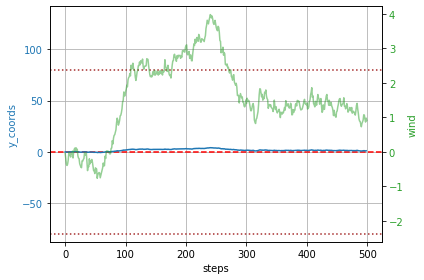

In [14]:
t="[[[5.0, -0.048006028], [9.999769, -0.21561193], [14.995118, -0.35934466], [19.98219, -0.39659122], [24.966436, -0.35812426], [29.953594, -0.24173924], [34.947746, -0.021682845], [39.9477, -0.097717516], [44.946743, -0.0572294], [49.94642, -0.1518706], [54.94411, -0.040562645], [59.943947, -0.07334263], [64.943405, 0.01943212], [69.94337, -0.17976329], [74.94014, -0.0092292875], [79.94013, 0.074658126], [84.939575, 0.1060183], [89.938446, 0.0358814], [94.93832, 0.115178816], [99.93699, -0.008223796], [104.93699, 0.0760521], [109.93641, -0.11720935], [114.935036, -0.18115568], [119.93175, -0.19808531], [124.927826, -0.34659514], [129.9158, -0.3978855], [134.89995, -0.44463912], [139.88013, -0.46129096], [144.85881, -0.26245463], [149.85191, -0.272842], [154.84447, -0.22167516], [159.83955, -0.19821209], [164.83562, -0.029560823], [169.83553, -0.06722446], [174.83508, -0.1001858], [179.83408, -0.038006093], [184.83392, -0.28497517], [189.8258, -0.54638046], [194.79585, -0.4096914], [199.77905, -0.4348328], [204.7601, -0.20342767], [209.75597, -0.3520418], [214.74356, -0.2648746], [219.73653, -0.30152717], [224.72743, -0.22191004], [229.7225, -0.29054266], [234.71405, -0.41751638], [239.6966, -0.5452048], [244.66678, -0.54037386], [249.6375, -0.63201183], [254.5974, -0.4665599], [259.57556, -0.48395005], [264.5521, -0.5007608], [269.52695, -0.76809126], [274.46762, -0.6672381], [279.42288, -0.6266304], [284.38345, -0.60114497], [289.3472, -0.6191932], [294.30872, -0.75413364], [299.25153, -0.68385327], [304.20453, -0.62119144], [309.1658, -0.5551413], [314.1349, -0.4624399], [319.11343, -0.32672802], [324.10275, -0.40743342], [329.08612, -0.40349144], [334.06982, -0.12672694], [339.0682, -0.19393174], [344.06445, 0.014207002], [349.06442, 0.025432162], [354.06436, 0.013231955], [359.06436, 0.018465985], [364.06433, -0.01474546], [369.0643, -0.040512376], [374.06412, -0.064106844], [379.06372, -0.054312095], [384.06342, 0.09965715], [389.06244, 0.1084021], [394.06125, 0.32241276], [399.05084, 0.22689115], [404.0457, 0.39847168], [409.0298, 0.47623098], [414.00708, 0.49438316], [418.98257, 0.56368226], [423.95068, 0.63746965], [428.90988, 0.84608734], [433.83777, 0.97381574], [438.74203, 0.91923666], [443.6568, 0.7717722], [448.5969, 0.8229981], [453.5287, 0.90438896], [458.4462, 1.0420208], [463.33643, 1.0579892], [468.2232, 1.1318588], [473.0934, 1.245973], [477.93567, 1.4412463], [482.72345, 1.4872684], [487.49713, 1.7330164], [492.1872, 1.6195794], [496.91763, 1.624476], [501.64636, 1.7488117], [506.33057, 1.8194718], [510.98776, 1.929855], [515.60034, 1.8844455], [520.2316, 2.0896277], [524.77405, 2.1509585], [529.2877, 2.173495], [533.7906, 2.2626016], [538.2493, 2.19898], [542.73987, 2.5083663], [547.0651, 2.3963003], [551.4535, 2.4704673], [555.80054, 2.566338], [560.0917, 2.4308739], [564.461, 2.371604], [568.86273, 2.3512769], [573.2754, 2.1656842], [577.78204, 2.0676112], [582.33453, 2.1732092], [586.8375, 2.31284], [591.27045, 2.3529365], [595.6822, 2.4935787], [600.01605, 2.4941313], [604.34955, 2.601564], [608.61945, 2.5222511], [612.93665, 2.6375911], [617.1844, 2.5848444], [621.46436, 2.571631], [625.7525, 2.6866393], [629.96936, 2.4846578], [634.3083, 2.392077], [638.699, 2.4626415], [643.0504, 2.485127], [647.3891, 2.4820366], [651.72955, 2.4947543], [656.06274, 2.6971052], [660.2729, 2.6761265], [664.49646, 2.6771965], [668.7193, 2.5013826], [673.04865, 2.3764775], [677.44775, 2.237883], [681.919, 2.177041], [686.42017, 2.2039697], [690.9082, 2.1665199], [695.41437, 2.1952114], [699.9067, 2.3198023], [704.336, 2.3136473], [708.7685, 2.2270112], [713.2451, 2.3643327], [717.6508, 2.2222247], [722.1298, 2.2495303], [726.595, 2.2624292], [731.05383, 2.3351002], [735.4751, 2.3289323], [739.89954, 2.2224095], [744.3786, 2.3055592], [748.8153, 2.2521958], [753.27936, 2.3519452], [757.69165, 2.358995], [762.10016, 2.2662487], [766.55707, 2.3121057], [770.99036, 2.2249546], [775.4681, 2.3504424], [779.88116, 2.3085356], [784.31635, 2.3761156], [788.71564, 2.6675043], [792.9452, 2.4762454], [797.28894, 2.4412205], [801.65247, 2.3547194], [806.0633, 2.3280373], [810.4882, 2.506533], [814.8146, 2.3802054], [819.2117, 2.2496843], [823.6768, 2.206442], [828.16364, 2.2351243], [832.6363, 2.1371732], [837.1565, 2.3169386], [841.5873, 2.5007231], [845.9174, 2.6303272], [850.1696, 2.6427715], [854.4141, 2.8022456], [858.55505, 2.8262763], [862.6796, 2.7363634], [866.86444, 2.7023113], [871.0713, 2.6206276], [875.32947, 2.7832575], [879.4832, 2.7112122], [883.6843, 2.7972581], [887.8286, 2.7793272], [891.985, 2.78694], [896.1362, 2.7970781], [900.2807, 2.7088404], [904.48334, 2.7668786], [908.64795, 2.7393234], [912.8308, 2.9316657], [916.88116, 2.9182243], [920.9412, 2.9401994], [924.98535, 2.8915534], [929.06445, 2.8903613], [933.14435, 3.0293891], [937.1222, 3.0832033], [941.0584, 3.0975482], [944.98334, 2.829295], [949.10583, 2.8087096], [953.24243, 2.8642676], [957.3407, 2.9080577], [961.408, 2.7056608], [965.61273, 2.805883], [969.7512, 2.8003163], [973.8937, 2.6409967], [978.1393, 2.635336], [982.38837, 2.8419538], [986.5022, 2.9862583], [990.51245, 3.1280618], [994.4131, 3.08179], [998.35046, 3.259818], [1002.1417, 3.1532762], [1006.02203, 3.2550747], [1009.8173, 3.3127527], [1013.56244, 3.2424786], [1017.3685, 3.2010314], [1021.20953, 3.400906], [1024.8748, 3.3440554], [1028.5919, 3.266017], [1032.3778, 3.1784394], [1036.2375, 3.1799078], [1040.0961, 3.2774134], [1043.8721, 3.2592347], [1047.6638, 3.2499423], [1051.4635, 3.2231905], [1055.286, 3.1936922], [1059.133, 3.2993202], [1062.89, 3.3637943], [1066.5894, 3.5769844], [1070.0829, 3.6704028], [1073.4783, 3.8120444], [1076.7137, 3.7585988], [1080.0111, 3.7063143], [1083.3672, 3.8068027], [1086.6089, 3.881079], [1089.7612, 3.9760597], [1092.7928, 3.954835], [1095.8522, 3.881279], [1099.0043, 3.933741], [1102.0906, 3.856936], [1105.2725, 3.738982], [1108.592, 3.6923661], [1111.9635, 3.7064629], [1115.3195, 3.8083627], [1118.5592, 3.6982663], [1121.9242, 3.5962927], [1125.398, 3.541818], [1128.9271, 3.5089324], [1132.489, 3.6355789], [1135.9216, 3.6089344], [1139.3822, 3.4641488], [1142.9877, 3.222431], [1146.8108, 3.2021627], [1150.6509, 2.868757], [1154.746, 2.962595], [1158.7738, 2.8944666], [1162.8508, 3.0302896], [1166.8279, 2.799513], [1170.9703, 2.8764894], [1175.06, 2.8415487], [1179.1742, 2.5309877], [1183.4863, 2.5370972], [1187.7948, 2.496011], [1192.1272, 2.5428455], [1196.4323, 2.4301202], [1200.802, 2.4471266], [1205.1622, 2.3294857], [1209.5864, 2.281984], [1214.0353, 2.361724], [1218.4424, 2.3701394], [1222.845, 2.1794853], [1227.345, 2.1463428], [1231.8608, 2.0749815], [1236.4099, 2.2187681], [1240.8906, 2.2340317], [1245.3638, 2.0183377], [1249.9384, 1.9736787], [1254.5323, 1.9255427], [1259.1467, 1.9845878], [1263.736, 1.875597], [1268.3708, 1.6285443], [1273.0981, 1.6390886], [1277.8219, 1.6306175], [1282.5486, 1.4146866], [1287.3442, 1.5740167], [1292.09, 1.6869527], [1296.7969, 1.6209894], [1301.5267, 1.5637162], [1306.276, 1.588601], [1311.0168, 1.4389591], [1315.8053, 1.4384227], [1320.594, 1.3263029], [1325.4149, 1.3004123], [1330.2428, 1.3410258], [1335.0596, 1.5016078], [1339.8287, 1.4002107], [1344.6288, 1.551415], [1349.382, 1.4748741], [1354.1594, 1.490582], [1358.9321, 1.4807948], [1363.7078, 1.4021891], [1368.5072, 1.3006036], [1373.3351, 1.1913093], [1378.191, 1.1902612], [1383.0474, 1.2628564], [1387.8853, 1.3589221], [1392.697, 1.3974928], [1397.4977, 1.2988443], [1402.326, 0.92244667], [1407.2402, 0.86067337], [1412.1656, 0.8193432], [1417.098, 0.94145113], [1422.0087, 0.97276443], [1426.9131, 1.058723], [1431.7997, 1.1591566], [1436.6635, 1.3707893], [1441.4719, 1.6522723], [1446.191, 1.8265756], [1450.8455, 1.8180884], [1455.5032, 1.710827], [1460.2014, 1.5929586], [1464.9408, 1.6642495], [1469.6558, 1.4960611], [1474.4266, 1.5724739], [1479.173, 1.5387532], [1483.9303, 1.7243282], [1488.6235, 1.7018973], [1493.325, 1.7915792], [1497.993, 1.616535], [1502.7245, 1.5416025], [1507.4808, 1.5124855], [1512.2466, 1.2595764], [1517.0853, 1.3309691], [1521.905, 1.3683232], [1526.7141, 1.3327271], [1531.5332, 1.3598251], [1536.3447, 1.283512], [1541.1772, 1.2662388], [1546.0142, 1.2399068], [1550.858, 1.1665865], [1555.72, 1.2835944], [1560.5525, 1.4969147], [1565.3231, 1.3157922], [1570.1469, 1.2234609], [1574.9949, 1.3042836], [1579.8218, 1.1762009], [1584.6814, 1.126239], [1589.553, 1.1739078], [1594.4132, 1.1805084], [1599.2719, 1.2324383], [1604.1176, 1.1322759], [1608.9877, 0.99075353], [1613.8885, 1.146958], [1618.7552, 1.1326045], [1623.6252, 1.0912989], [1628.5046, 1.1470252], [1633.3713, 1.1281056], [1638.2424, 1.2126809], [1643.0931, 1.284093], [1647.9254, 1.2077949], [1652.7773, 1.4810157], [1657.553, 1.371254], [1662.3613, 1.3251415], [1667.1825, 1.3813887], [1671.9879, 1.3923533], [1676.79, 1.2841476], [1681.6224, 1.2666284], [1686.4592, 1.2753142], [1691.294, 1.4065739], [1696.092, 1.3483025], [1700.9067, 1.0714067], [1705.7906, 1.0752838], [1710.6736, 1.2227662], [1715.5219, 1.1381032], [1720.3905, 1.2126291], [1725.2413, 1.2023625], [1730.0946, 1.3680493], [1734.9038, 1.397555], [1739.7045, 1.3278434], [1744.5249, 1.4876777], [1749.2985, 1.4823782], [1754.0737, 1.451459], [1758.8584, 1.4628961], [1763.6396, 1.3503536], [1768.4537, 1.2628138], [1773.2917, 1.2115403], [1778.1427, 1.2261881], [1782.99, 1.2374939], [1787.8345, 1.2972627], [1792.6632, 1.3705788], [1797.4717, 1.4650992], [1802.2522, 1.5192064], [1807.0159, 1.3926028], [1811.818, 1.388542], [1816.6213, 1.3628554], [1821.432, 1.4169058], [1826.227, 1.2384174], [1831.0713, 1.2583936], [1835.9103, 1.2981983], [1840.7389, 1.462497], [1845.5201, 1.4939023], [1850.2917, 1.6488268], [1855.0121, 1.7240664], [1859.7054, 1.8565607], [1864.348, 1.5783801], [1869.0923, 1.6222957], [1873.8218, 1.3947384], [1878.6233, 1.3622407], [1883.4342, 1.3019003], [1888.2617, 1.460777], [1893.0436, 1.416689], [1897.8387, 1.3505493], [1902.6528, 1.4915597], [1907.4252, 1.6592067], [1912.1418, 1.5690954], [1916.8893, 1.5359666], [1921.6475, 1.3796738], [1926.4534, 1.4358082], [1931.2428, 1.5427797], [1935.9988, 1.3339394], [1940.8176, 1.1433692], [1945.6852, 1.1773788], [1950.5446, 1.3590051], [1955.3563, 1.2562547], [1960.1959, 1.2294923], [1965.0424, 1.4350576], [1969.832, 1.5024524], [1974.601, 1.620076], [1979.3312, 1.6602861], [1984.0475, 1.4827223], [1988.8226, 1.4864262], [1993.5966, 1.3503807], [1998.4108, 1.4927834], [2003.1827, 1.3428833], [2007.999, 1.3982354], [2012.7994, 1.4295307], [2017.5908, 1.3256235], [2022.4119, 1.2853414], [2027.2438, 1.1989069], [2032.0979, 1.0494748], [2036.9866, 1.2019266], [2041.84, 1.0447307], [2046.7296, 1.0674366], [2051.6143, 1.000812], [2056.5132, 1.1560051], [2061.378, 1.182518], [2066.236, 1.2977136], [2071.0647, 1.3794496], [2075.8706, 1.4954977], [2080.6416, 1.536076], [2085.4, 1.542283], [2090.156, 1.3649908], [2094.966, 1.3182886], [2099.7893, 1.3671416], [2104.5986, 1.3844362], [2109.4033, 1.4081293], [2114.201, 1.5643916], [2118.9497, 1.3222903], [2123.7717, 1.3243127], [2128.5933, 1.2443042], [2133.436, 1.3019197], [2138.2634, 1.3949406], [2143.065, 1.3144288], [2147.8892, 1.1481729], [2152.7554, 1.1880939], [2157.6123, 1.20695], [2162.4644, 1.2822239], [2167.297, 1.239223], [2172.141, 1.1840734], [2176.999, 1.2824308], [2181.8318, 1.1186233], [2186.7048, 1.1624392], [2191.5679, 1.1739304], [2196.4282, 1.1482824], [2201.2944, 1.0993316], [2206.172, 1.0635875], [2211.0579, 1.185295], [2215.9153, 1.3475991], [2220.7302, 1.4022386], [2225.5295, 1.2425249], [2230.3728, 1.118615], [2235.2458, 0.96325755], [2240.1523, 0.8926409], [2245.072, 0.8789436], [2249.9941, 0.8034186], [2254.9292, 0.724731], [2259.8765, 0.82087016], [2264.8086, 0.86554277], [2269.733, 0.9196359], [2274.6477, 1.0721122], [2279.5315, 1.0630894], [2284.417, 0.94495696], [2289.327, 0.86097044], [2294.2522, 0.9750285], [2299.1562, 0.9069473]]]"
d="[[[-0.048006029638756643], [-0.2156119056366557], [-0.35934472534011874], [-0.3965915571811571], [-0.35812403408225596], [-0.24173899340622945], [-0.021682600723178666], [-0.09771747180697926], [-0.057229383281376944], [-0.15187059344198317], [-0.040563049348948985], [-0.07334258340633512], [0.019432148035747394], [-0.1797633063688127], [-0.009229001491433832], [0.07465812278202223], [0.10601827183041818], [0.03588110369975099], [0.11517884838016834], [-0.008223610649063191], [0.07605209715377029], [-0.11720935002261995], [-0.1811553256398053], [-0.19808563056804962], [-0.3465948325773502], [-0.3978853608143095], [-0.4446396322982592], [-0.46129081578674647], [-0.2624546742569773], [-0.27284236235777104], [-0.22167517091317285], [-0.19821192635664342], [-0.029560742168952915], [-0.06722443529466243], [-0.1001858352997337], [-0.03800629852670441], [-0.28497518580971215], [-0.5463802701019302], [-0.40969093759676245], [-0.43483242976798664], [-0.20342785526012325], [-0.352042129835164], [-0.26487480390650286], [-0.301527563503402], [-0.22190986931823597], [-0.29054263870118335], [-0.4175166941150956], [-0.5452044626000973], [-0.5403740134004488], [-0.6320120026964768], [-0.4665600522828258], [-0.4839501568547274], [-0.5007607422587235], [-0.7680914861494366], [-0.6672378127587185], [-0.6266303209824255], [-0.601144551881895], [-0.6191932246735007], [-0.7541334208363251], [-0.6838536776929043], [-0.6211911469093199], [-0.5551408944348443], [-0.4624395614294431], [-0.32672812486248604], [-0.4074333871537409], [-0.40349102044873164], [-0.12672651285871026], [-0.19393180291003886], [0.014206747546113327], [0.02543215996508269], [0.013231993429159549], [0.0184660296816912], [-0.014745444677063964], [-0.040512416799360434], [-0.06410686988170314], [-0.05431204963298186], [0.09965714085953994], [0.1084020588995683], [0.3224126498580099], [0.2268913906267521], [0.39847154837234705], [0.4762312989885392], [0.49438317280541666], [0.5636811296340783], [0.6374693513863857], [0.8460877298076189], [0.973815381685881], [0.9192369410174206], [0.7717725388762566], [0.8229978641696116], [0.9043888980738559], [1.0420208539516809], [1.0579883595112114], [1.1318596227769517], [1.2459742094145292], [1.4412431946087705], [1.4872722311735391], [1.7330178743749785], [1.6195830825939022], [1.6244766058838498], [1.7488157118095278], [1.819470096356093], [1.9298531792730191], [1.8844405167287344], [2.0896321420336625], [2.1509609618577583], [2.1734965535653066], [2.262606498890172], [2.198978455354176], [2.508366181131107], [2.3963040409999152], [2.4704669254143035], [2.5663407863679075], [2.4308758946163387], [2.371599914779069], [2.3512730476749715], [2.1656872456771508], [2.0676071046779025], [2.1732078524826477], [2.312840976646715], [2.352936461403946], [2.4935821686539406], [2.4941325059719635], [2.6015626914780823], [2.522247202647998], [2.637589882246239], [2.5848433831480584], [2.571626477140489], [2.686437084701212], [2.484658408059774], [2.3920792276883986], [2.4626445033359152], [2.4851254354674825], [2.4820395417340326], [2.4947577422718235], [2.697101015687243], [2.676131132468058], [2.677200203598617], [2.5013861013709304], [2.3764747141021054], [2.2378857723248786], [2.1770378388896754], [2.203968610395029], [2.166520206937422], [2.1953581731303062], [2.319800876947405], [2.313644984390732], [2.227014051376983], [2.3643313282283325], [2.2222221361107612], [2.249527734710235], [2.2628990230897283], [2.3351008254401027], [2.3289322161758474], [2.2224072682659237], [2.305371903400893], [2.2521966950202534], [2.3519491361944915], [2.3589998191590413], [2.266243750966317], [2.3121070417471987], [2.2249589148840903], [2.3504377945664485], [2.3085332539834535], [2.376119793039489], [2.6675089657847275], [2.475407695089115], [2.441225037046574], [2.3547188809855797], [2.3280378555582857], [2.5065358108596487], [2.3802024680388287], [2.249688742993007], [2.20675785123448], [2.2351222792858567], [2.1371688749609237], [2.316935376476611], [2.500724598143816], [2.6296041194956397], [2.6427740937779425], [2.8022440747636073], [2.82628088125275], [2.736367133298212], [2.702307785689846], [2.620626221999882], [2.783259912424634], [2.711214602948415], [2.7972561276183097], [2.7793289662897065], [2.7869429308699947], [2.7970779722693004], [2.7088422916496118], [2.7668782386318775], [2.739324859126354], [2.9316622511875483], [2.9182286576490943], [2.94019500135825], [2.8915540806308244], [2.89035781587368], [3.029387864231119], [3.0832041481844907], [3.0975451132571363], [2.829296483002911], [2.808704753416637], [2.86426806420617], [2.908060092573833], [2.7056631354319034], [2.805882134760172], [2.800313197278461], [2.6406803577860383], [2.6353393671319054], [2.8419577163354144], [2.9862544960853117], [3.128063656189192], [3.0817880483787317], [3.259818299183327], [3.1532781251004662], [3.2550785229142623], [3.3127480160030194], [3.2424757203757197], [3.2010329988491577], [3.400904470027322], [3.3440593700926167], [3.2660215542806066], [3.1784423879311294], [3.1799084276361187], [3.2774155217506653], [3.259231371973021], [3.249937767757195], [3.2232481475086807], [3.1936917360375503], [3.2993179461141215], [3.3637941732105356], [3.576980013583636], [3.67039828225664], [3.8120417483420717], [3.758594306016485], [3.706315645882294], [3.8067983569858894], [3.881076248474285], [3.976060638158471], [3.954835320427942], [3.88127408623236], [3.9337419784455028], [3.8569349226942675], [3.7389859825253016], [3.6923641928160005], [3.7064666541578095], [3.8083600173946595], [3.6982634626335145], [3.5962965729231255], [3.5418151593356058], [3.5089343685521475], [3.6355765345514044], [3.608935505011143], [3.4641442993551133], [3.222432287580987], [3.202161664489365], [2.868754265101603], [2.9625979767027544], [2.89446163888143], [3.0302931315719386], [2.799513469388554], [2.8769763644405586], [2.841549187324289], [2.530989068804748], [2.5370994989270077], [2.4960138394894495], [2.54284426801178], [2.4301249449906335], [2.4471262912632463], [2.329488966226681], [2.2819885574435204], [2.361719816701318], [2.370135309352505], [2.1794860603634385], [2.146347441557793], [2.0749787129773916], [2.218766567554167], [2.2340336633385975], [2.0183359018519074], [1.9736810909848743], [1.9255440603834109], [1.984585024967262], [1.8755992115972884], [1.628547278655298], [1.639084340608569], [1.630618937877972], [1.4146890147744764], [1.5740200920475529], [1.6869559965430325], [1.6209867422631483], [1.5637167637349152], [1.5886048072029468], [1.4389581797652644], [1.438423507132762], [1.32630021457469], [1.3004094604842358], [1.3410234490915376], [1.501612040055324], [1.4002129218169972], [1.5514142414500371], [1.4748691183255247], [1.490577910884721], [1.4807927432473866], [1.4021843235981444], [1.3006045793863665], [1.1913056472991104], [1.190261991143064], [1.2628551158430101], [1.3589257313559282], [1.3974905971780132], [1.2988415679265986], [0.9224423562892337], [0.8606737002120459], [0.8193428122967041], [0.9414509692702882], [0.9727642904857559], [1.058722565597539], [1.159153607921365], [1.3707926696560757], [1.6522730577355678], [1.8265733123011834], [1.8180927441328285], [1.710828644454104], [1.592961529198432], [1.6642510251182105], [1.4960614619283796], [1.5724758009063415], [1.538749229724977], [1.7243250302382358], [1.7018991530780978], [1.7915819058760545], [1.6165357876842128], [1.541597559987621], [1.5124829274518108], [1.2595810191663912], [1.3309726190559656], [1.3683241399247534], [1.3327238400470691], [1.3598280812987078], [1.28351678822907], [1.2662368035131384], [1.2399080898884414], [1.166589628577426], [1.2836745538894254], [1.496910342391654], [1.315787527918981], [1.2234586826141542], [1.3042826853930332], [1.1761972998087564], [1.1262380423708727], [1.173908859857469], [1.1805105364910895], [1.2324399439854532], [1.132277667859618], [0.9907575763763514], [1.1469585160861713], [1.1326064843302048], [1.0912944350077862], [1.14702631441561], [1.1281103761797262], [1.2126852778064143], [1.284092150684645], [1.2077917749495086], [1.4810108251165564], [1.3712582607057975], [1.3251376398853978], [1.3813870827965449], [1.3923546163622167], [1.284144319300971], [1.2666307999843351], [1.275315762453488], [1.4065696923162103], [1.3482986466020708], [1.071404241772512], [1.0753055769389324], [1.2227623692514393], [1.1381071803812464], [1.21262576062205], [1.2023635046644077], [1.3680466803099185], [1.3975557703077843], [1.32783847126453], [1.4876741545507364], [1.4823805570607334], [1.4514608933878639], [1.4628969858453476], [1.3503574810190098], [1.2628102948870166], [1.2115364875688095], [1.2261876939200744], [1.2374958476157734], [1.2972588107864143], [1.3705760873585575], [1.4651003951144708], [1.5192071903228332], [1.392606460565523], [1.38853922974041], [1.3628533559833684], [1.416910379026517], [1.2384216299237352], [1.2583962807749303], [1.2981946583370636], [1.4624986568480398], [1.4939053567835845], [1.6488244489260147], [1.7240695174634584], [1.8565643332226154], [1.578379419655716], [1.6222956157695765], [1.394742745581692], [1.362242210402866], [1.3018996281128312], [1.4607767128470588], [1.416692017131439], [1.3505270396782905], [1.4915603534870705], [1.6592070328849613], [1.5690985635381192], [1.5359713315906207], [1.379677215697145], [1.4358043064565003], [1.542781527624087], [1.3339397050762467], [1.1433698048336167], [1.1773787480180475], [1.3590063297109571], [1.2562595666246534], [1.2294876062910698], [1.4350552786738182], [1.502454725692069], [1.6200736465076258], [1.6602901569762851], [1.4827261719881921], [1.4864239632951584], [1.3503844301834507], [1.4927826869467546], [1.3428800063006092], [1.39823206906603], [1.4295352618525696], [1.32562282369832], [1.2853378645455587], [1.1989055533959907], [1.049477904814962], [1.201921719223341], [1.044734108984175], [1.0674358705034717], [1.0008154584308293], [1.1551931273143563], [1.182522821584081], [1.2977157254866767], [1.3794458935544984], [1.495498120534489], [1.536073695210935], [1.5422871147076709], [1.3649878617417648], [1.3182877064779757], [1.367143020294651], [1.3844346236775147], [1.408133141671951], [1.5643922062046778], [1.3222886808558856], [1.32431242886426], [1.2443014577621772], [1.301915525819439], [1.3949409719854189], [1.3144281396214021], [1.1481741306888225], [1.1880909883999136], [1.2069460794941376], [1.2822239258391164], [1.2392191381903994], [1.18407042427431], [1.2824273061752405], [1.118622543902616], [1.162435924447792], [1.1739311612037293], [1.1482819739722232], [1.099329241551131], [1.063585964063394], [1.1852974119814172], [1.3475941217468796], [1.40223947659489], [1.2425262773950496], [1.1186101039974243], [0.963262598192136], [0.8926413049507445], [0.8789437499827014], [0.8034189652191239], [0.7247314342302662], [0.8208701367165245], [0.8655425801869486], [0.9196361213261164], [1.0721123857269634], [1.0630870904754577], [0.944957644861564], [0.8609704474887172], [0.9750281008137308], [0.9069477591835433]]]"
combine_distri_trajectory(json.loads(t),json.loads(d))